# Imports

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE

In [ ]:
import datetime as dt

# Data

In [ ]:
online = pd.read_csv("./Data/online12m.csv",parse_dates=['InvoiceDate'],index_col=0)

In [ ]:
online['TotalSum'] = online.Quantity * online.UnitPrice

In [ ]:
online.head(3)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalSum
416792,572558,22745,POPPY'S PLAYHOUSE BEDROOM,6,2011-10-25 08:26:00,2.10,14286,United Kingdom,12.60
482904,577485,23196,VINTAGE LEAF MAGNETIC NOTEPAD,1,2011-11-20 11:56:00,1.45,16360,United Kingdom,1.45
263743,560034,23299,FOOD COVER WITH BEADS SET 2,6,2011-07-14 13:35:00,3.75,13933,United Kingdom,22.50


# Add RFM Features

* Recency: Number of Days since last purchase
* Frequency: Number of Purchases
* Monetary: Total Amount Spent

In [ ]:
snapshot_date = max(online.InvoiceDate) + dt.timedelta(days=1)

In [ ]:
# Calculate Recency, Frequency and Monetary value for each customer 
RFM_DF = online.groupby(['CustomerID']).agg({
    'InvoiceDate': lambda x: (snapshot_date - x.max()).days,
    'InvoiceNo': 'count',
    'TotalSum': 'sum'})

# Rename the columns 
RFM_DF.rename(columns={'InvoiceDate': 'Recency',
                         'InvoiceNo': 'Frequency',
                         'TotalSum': 'MonetaryValue'}, inplace=True)

RFM_DF.head()

,Recency,Frequency,MonetaryValue
CustomerID,,,
12747,2,27,992.82
12748,1,967,7522.06
12749,4,37,813.45
12820,3,17,268.02
12822,71,9,146.15


# Building RFM Segments

Want to segment customers on quartile groupings of each RFM characteristic

In [ ]:
# Create labels for all quartiles
r_labels = range(4, 0, -1); f_labels = range(1, 5); m_labels = range(1, 5)

# Creat the groupings
r_groups = pd.qcut(RFM_DF['Recency'], q=4, labels=r_labels) 
f_groups = pd.qcut(RFM_DF['Frequency'], q=4, labels=f_labels)
m_groups = pd.qcut(RFM_DF['MonetaryValue'], q=4, labels=m_labels)
 
RFM_DF = RFM_DF.assign(R=r_groups.values, F=f_groups.values, M=m_groups.values)

In [ ]:
RFM_DF.loc[:,["R","F","M"]] = RFM_DF.loc[:,["R","F","M"]].astype("int")

In [ ]:
# Calculate RFM_Score
RFM_DF['RFM_Score'] = RFM_DF[['R','F','M']].sum(axis=1)

In [ ]:
RFM_DF["RFM_Segment"] = RFM_DF.apply(lambda x: (str(x.R) + str(x.F) + str(x.M)).replace(".","").replace("0",""),axis=1)

In [ ]:
RFM_DF.head()

,Recency,Frequency,MonetaryValue,R,F,M,RFM_Score,RFM_Segment
CustomerID,,,,,,,,
12747,2,27,992.82,4,4,4,12,444
12748,1,967,7522.06,4,4,4,12,444
12749,4,37,813.45,4,4,4,12,444
12820,3,17,268.02,4,3,3,10,433
12822,71,9,146.15,2,2,3,7,223


**Want reduce segmnts into groups of 3 and 5**

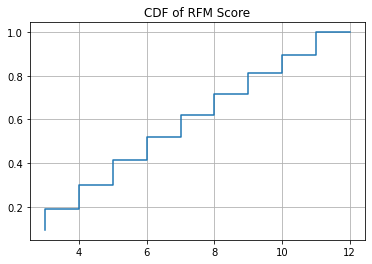

In [ ]:
# See CDF of RFM score groups
counts = RFM_DF.groupby("RFM_Score").size().cumsum()/RFM_DF.shape[0]
plt.step(counts.index,counts)
plt.grid()
plt.title("CDF of RFM Score");

In [ ]:
# Define rfm_level function
def rfm_level_3(df):
    if df['RFM_Score'] >= 9:
        return 'Top'
    elif ((df['RFM_Score'] >= 6) and (df['RFM_Score'] < 9)):
        return 'Middle'
    else:
        return 'Low'

def rfm_level_5(df):
    if df['RFM_Score'] >= 11:
        return 'Whale'
    elif ((df['RFM_Score'] >= 9) and (df['RFM_Score'] < 11)):
        return 'Safe'
    elif ((df['RFM_Score'] >= 7) and (df['RFM_Score'] < 8)):
        return 'Middle'
    elif ((df['RFM_Score'] >= 5) and (df['RFM_Score'] < 7)):
        return 'Concerning'
    else:
        return 'ImmediatelyAddress'

# Create a new variable RFM_Level
RFM_DF['RFM_Level_3'] = RFM_DF.apply(rfm_level_3, axis=1)
RFM_DF['RFM_Level_5'] = RFM_DF.apply(rfm_level_5, axis=1)

RFM_DF.head()

,Recency,Frequency,MonetaryValue,R,F,M,RFM_Score,RFM_Segment,RFM_Level_3,RFM_Level_5
CustomerID,,,,,,,,,,
12747,2,27,992.82,4,4,4,12,444,Top,Whale
12748,1,967,7522.06,4,4,4,12,444,Top,Whale
12749,4,37,813.45,4,4,4,12,444,Top,Whale
12820,3,17,268.02,4,3,3,10,433,Top,Safe
12822,71,9,146.15,2,2,3,7,223,Middle,Middle


In [ ]:
RFM_DF.to_csv(path + "/RFM_DF.csv")

# Analyzing Customer Segments

Want to look at the mean values across segments

In [ ]:
# Calculate average values for each RFM_Level, and return a size of each segment 
rfm_level_agg = RFM_DF.groupby('RFM_Level_3').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
  
  	# Return the size of each segment
    'MonetaryValue': ['mean', 'count']
}).round(1)

rfm_level_agg

Recency Frequency MonetaryValue      
               mean      mean          mean count
RFM_Level_3                                      
Low           190.0       3.3          53.5  1100
Middle         84.8       9.2         169.5  1199
Top            27.4      40.1         817.6  1402

In [ ]:
# Calculate average values for each RFM_Level, and return a size of each segment 
rfm_level_agg = RFM_DF.groupby('RFM_Level_5').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
  
  	# Return the size of each segment
    'MonetaryValue': ['mean', 'count']
}).round(1)

rfm_level_agg = rfm_level_agg.reindex(["ImmediatelyAddress","Concerning","Middle","Safe","Whale"])
rfm_level_agg

Recency Frequency MonetaryValue      
                      mean      mean          mean count
RFM_Level_5                                             
ImmediatelyAddress   161.9       6.2          95.2  1076
Concerning           124.7       5.4         115.6   839
Middle                82.8       8.9         163.1   384
Safe                  40.5      20.7         385.7   711
Whale                 13.9      60.1        1262.0   691

# Visualize Segments

Note: We take the log and standardize to produce a more clear picture and because the dimension reduction works better 

In [ ]:
scaler = StandardScaler()
X_normalized_array = scaler.fit_transform(np.log(RFM_DF[['Recency','Frequency','MonetaryValue']]))
X_normalized = pd.DataFrame(X_normalized_array, index=RFM_DF.index, columns=['Recency','Frequency','MonetaryValue'])
X_normalized_with_segs = X_normalized.assign(level_3 = RFM_DF.RFM_Level_3,level_5 = RFM_DF.RFM_Level_5)

## 2-D Visualization with TSNE

In [ ]:
m = TSNE(learning_rate=50)
tsne_features = m.fit_transform(X_normalized)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,


In [ ]:
df_tsne = pd.DataFrame({'level_3':X_normalized_with_segs.level_3,'level_5':X_normalized_with_segs.level_5})
df_tsne['t_SNE_PC_1'] = tsne_features[:,0]
df_tsne['t_SNE_PC_2'] = tsne_features[:,1]

In [ ]:
df_tsne.to_csv(path + "/tsne.csv")

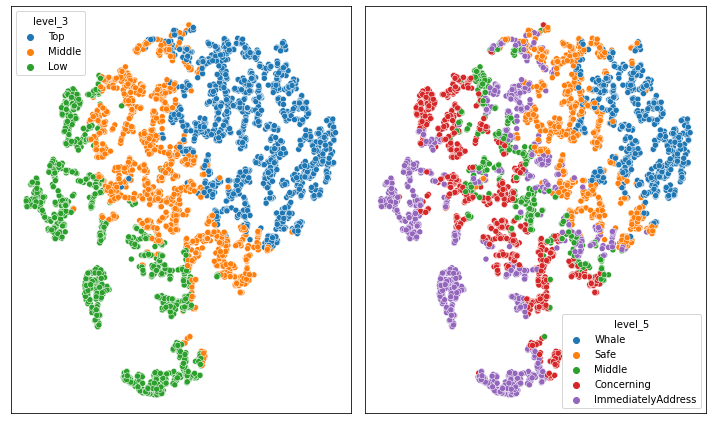

In [ ]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(10,6))

sns.scatterplot(x="t_SNE_PC_1", y="t_SNE_PC_2",data=df_tsne,hue="level_3",ax=ax1)
sns.scatterplot(x="t_SNE_PC_1", y="t_SNE_PC_2",data=df_tsne,hue="level_5",ax=ax2)
ax1.get_xaxis().set_visible(False)
ax1.axes.get_yaxis().set_visible(False)
ax2.get_xaxis().set_visible(False)
ax2.axes.get_yaxis().set_visible(False)
plt.tight_layout()

We can see stronger separation among the three segments compared to the five segments

## 3-D Visualization

In [ ]:
fig = px.scatter_3d(X_normalized_with_segs, x='MonetaryValue', y='Recency', z='Frequency',
              color='level_3')
fig.show() 

In [ ]:
fig = px.scatter_3d(X_normalized_with_segs, x='MonetaryValue', y='Recency', z='Frequency',
              color='level_5')
fig.show() 

These plots are to ensure they the segmenation was performed correctly and both illustrate that it was